# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 36449 (delta 160), reused 53 (delta 53), pack-reused 36127 (from 4)
Receiving objects: 100% (36449/36449), 22.26 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (26249/26249), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # logical scale; actual layers scaled below to match 0.5/0.25

backbone:
  - [-1, 1, TorchVision, [768, mobilenet_v3_small, DEFAULT, True, 2, True]]  # 0

head:
  # Extract features from MobileNetV3 Small
  - [0, 1, Index, [24, 3]]           # 1: P3 raw (stride 8)
  - [0, 1, Index, [48, 9]]           # 2: P4 raw (stride 16)
  - [0, 1, Index, [576, 13]]         # 3: P5 raw (stride 32)

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [1, 1, Conv, [64, 1, 1]]         # 4: P3 → 64
  - [2, 1, Conv, [128, 1, 1]]        # 5: P4 → 128
  - [3, 1, Conv, [256, 1, 1]]        # 6: P5 → 256

  # FPN: P5 → P4
  - [6, 1, nn.Upsample, [None, 2, "nearest"]]  # 7
  - [[7, 5], 1, Concat, [1]]                   # 8
  - [-1, 1, C3k2, [128, False]]                # 9 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 4], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [64, False]]                 # 12 (256 → 64)

  # PAN: P3 → P4
  - [12, 1, Conv, [64, 3, 2]]                  # 13
  - [[13, 9], 1, Concat, [1]]                  # 14
  - [-1, 1, C3k2, [128, False]]                # 15

  # PAN: P4 → P5
  - [15, 1, Conv, [128, 3, 2]]                 # 16
  - [[16, 6], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [256, True]]                 # 18

  # Final detection layers
  - [[12, 15, 18], 1, Detect, [nc]]            # 19



  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 16, 320, 320])
# 2 torch.Size([1, 16, 160, 160])
# 3 torch.Size([1, 24, 80, 80])
# 4 torch.Size([1, 24, 80, 80])
# 5 torch.Size([1, 40, 40, 40])
# 6 torch.Size([1, 40, 40, 40])
# 7 torch.Size([1, 40, 40, 40])
# 8 torch.Size([1, 48, 40, 40])
# 9 torch.Size([1, 48, 40, 40])
# 10 torch.Size([1, 96, 20, 20])
# 11 torch.Size([1, 96, 20, 20])
# 12 torch.Size([1, 96, 20, 20])
# 13 torch.Size([1, 576, 20, 20])
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 53.2MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=10,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    927008  ultralytics.nn.modules.block.TorchVision     ['mobilenet_v3_small', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [3]                           
  2                   0  1         0  ultralytics.nn.modules.conv.Index            [9]                           
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [13]                          
  4                   1  1      1664  ultralytics.nn.modules.conv.Conv             [24, 64, 1, 1]                
  5                   2  1      6400  ultralytics.nn.modules.conv.Conv             [48, 128, 1, 1]               
  6                   3  1    147968  ultralytics.nn.modules.conv.Conv             [576, 25

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:02<00:00, 191.71it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 163.27it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 78 weight(decay=0.0), 103 weight(decay=0.0005), 102 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.38G      3.991      94.46      3.547         38        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300       2.7G      4.306      24.14      3.293         45        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        200       1017   0.000157    0.00688   7.92e-05   1.69e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.71G      4.148       6.61      2.092         41        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        200       1017    0.00256      0.148     0.0119    0.00216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.71G      3.771      4.212      1.667         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        200       1017      0.119      0.109     0.0278     0.0056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.71G      3.516      3.556      1.482         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


                   all        200       1017      0.096      0.153     0.0315    0.00576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.71G      3.366      2.948      1.382         17        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


                   all        200       1017      0.284      0.182      0.111     0.0237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.71G      3.328      2.709      1.355         47        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


                   all        200       1017      0.303      0.199      0.132      0.028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.71G      3.263      2.615      1.319          7        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


                   all        200       1017      0.282      0.226      0.125     0.0257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.71G       3.17       2.31      1.281         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        200       1017      0.335       0.26       0.18     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.71G      3.156       2.24      1.232         42        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        200       1017      0.382      0.283      0.195     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.71G      3.103      2.156      1.163         68        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


                   all        200       1017      0.386      0.277      0.201     0.0474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.71G      3.057      2.086      1.207         30        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200       1017      0.328      0.268      0.179     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.71G       3.04      2.006      1.198         15        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017      0.357      0.277      0.195     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.71G      3.095      1.946      1.192         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.393      0.293        0.2     0.0489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.71G       3.02      1.874      1.185         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


                   all        200       1017      0.411      0.316      0.237     0.0545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.71G      2.989      1.871      1.235         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        200       1017      0.445      0.315      0.254      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.71G      3.009       1.78      1.185         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

                   all        200       1017      0.437      0.316      0.251     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.71G      2.945      1.761      1.186         46        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        200       1017      0.403        0.3      0.224     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.71G      2.879       1.66      1.148         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


                   all        200       1017      0.455      0.328      0.249     0.0605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.71G      2.895       1.67      1.137         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200       1017      0.409      0.323       0.25     0.0598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.71G      2.911      1.584      1.158         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        200       1017      0.459      0.364      0.285     0.0695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.71G      2.954      1.606      1.171         29        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


                   all        200       1017      0.417      0.295      0.248     0.0597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.71G      2.915      1.615      1.164         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200       1017      0.399      0.292      0.227     0.0551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.71G      2.866      1.557       1.15         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


                   all        200       1017      0.469      0.347      0.259     0.0671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.71G      2.913      1.553      1.174         35        640: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.476      0.346      0.296     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.71G      2.872      1.548      1.147         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200       1017      0.446      0.325      0.261     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.71G      2.889      1.498      1.117         15        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200       1017      0.378      0.275      0.185     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.71G      2.856      1.492      1.115         43        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017      0.444      0.339      0.284     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.71G      2.835      1.502       1.13         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        200       1017      0.483      0.364      0.308     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.71G      2.739      1.404      1.117         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200       1017      0.486      0.377      0.323     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.71G      2.787      1.461      1.119         24        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

                   all        200       1017       0.46      0.386       0.31     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.71G      2.786      1.401      1.088         47        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.515      0.378      0.331      0.087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.71G      2.731      1.396      1.099         31        640: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017      0.499      0.354      0.295     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.71G      2.782       1.37      1.123         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all        200       1017      0.489      0.331      0.294     0.0786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.71G      2.818      1.398      1.087         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200       1017      0.441      0.328      0.264     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.71G      2.783      1.389      1.147         51        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200       1017      0.532       0.38      0.354     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.71G      2.794      1.382      1.108         32        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        200       1017      0.512      0.384      0.346     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.71G      2.736      1.346      1.098         47        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        200       1017      0.502      0.382       0.34     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.71G       2.67      1.303       1.07         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        200       1017      0.537      0.381      0.349     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.71G      2.725      1.349      1.134         18        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200       1017      0.512      0.395      0.345     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.71G      2.661      1.331      1.085         24        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.521      0.403      0.353     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.71G      2.686      1.348      1.105         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


                   all        200       1017      0.513      0.391      0.333     0.0936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.71G      2.684       1.33      1.066         36        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        200       1017      0.484      0.382      0.329     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.71G      2.686      1.286      1.105         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


                   all        200       1017      0.524      0.386      0.368      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.71G      2.607      1.246      1.079         54        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        200       1017      0.536      0.393      0.357        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.71G      2.637      1.285      1.112         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200       1017      0.499       0.39      0.326     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.71G       2.67      1.282      1.089         38        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


                   all        200       1017      0.511      0.415      0.356     0.0989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.71G      2.585      1.263      1.105         14        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

                   all        200       1017      0.544      0.404      0.388      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.71G      2.617      1.272      1.061         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200       1017      0.554      0.412      0.386      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.71G      2.674      1.265      1.068         12        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        200       1017      0.503      0.414      0.374      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.71G      2.668      1.279      1.117         24        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200       1017      0.561      0.412      0.384      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.71G      2.565      1.217      1.094         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200       1017      0.566      0.409       0.38      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.71G      2.628      1.261      1.075         62        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017      0.539      0.388      0.346     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.71G      2.536      1.215      1.098         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        200       1017       0.55      0.416      0.384      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.71G      2.563      1.215      1.063         39        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200       1017      0.535      0.416      0.359      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.71G      2.561      1.183      1.053         12        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


                   all        200       1017      0.566      0.413       0.38      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.71G      2.547       1.23      1.072         52        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200       1017      0.575       0.39      0.358     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.71G      2.596      1.217      1.077         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        200       1017      0.506        0.4      0.358      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.71G       2.61      1.228      1.077         34        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.519       0.41      0.381      0.111
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 49, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



59 epochs completed in 0.282 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.9MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.9MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 197 layers, 2,299,555 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


                   all        200       1017      0.553      0.412      0.386      0.114


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dfdd9d39300>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
!zip -r yolo11_mobilenet.zip /kaggle/working/model

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/val_batch2_pred.jpg (deflated 14%)
  adding: kaggle/working/model/P_curve.png (deflated 15%)
  adding: kaggle/working/model/val_batch1_labels.jpg (deflated 8%)
  adding: kaggle/working/model/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/model/args.yaml (deflated 54%)
  adding: kaggle/working/model/R_curve.png (deflated 21%)
  adding: kaggle/working/model/train_batch2.jpg (deflated 7%)
  adding: kaggle/working/model/train_batch1.jpg (deflated 4%)
  adding: kaggle/working/model/val_batch1_pred.jpg (deflated 8%)
  adding: kaggle/working/model/val_batch2_labels.jpg (deflated 13%)
  adding: kaggle/working/model/confusion_matrix.png (deflated 37%)
  adding: kaggle/working/model/labels.jpg (deflated 34%)
  adding: kaggle/working/model/labels_correlogram.jpg (deflated 40%)
  adding: kaggle/working/model/results.png (deflated 7%)
  adding: kaggle/working/model/train_batch0.jpg (deflated 7%)
  ad

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 3 humans, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


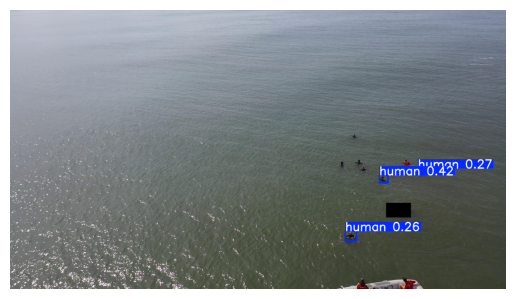

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 197 layers, 2,299,555 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 713.59it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


                   all        200       1072      0.616      0.454      0.452      0.138


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.5ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dfea3ef6b00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0

In [8]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)